In [1]:
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM
from fit.utils import convert2DFT, pol2cart
from fit.utils.tomo_utils import get_polar_rfft_coords_2D
from fit.transformers.PositionalEncoding2D import PositionalEncoding2D

from matplotlib import pyplot as plt

import torch

import numpy as np

# FIT for Super-Resolution

We train FIT for super-resolution auto-regressively. Therefor our data has to be ordered such that each prefix describes the whole image at reduced resolution. 

In [2]:
# dm = MNIST_SResFITDM(root_dir='./data/', batch_size=4)

dm = CelebA_SResFITDM(root_dir='./data/CelebA/', batch_size=4)

dm.prepare_data()
dm.setup()

Transformers require a positional encoding to make use of location information. We provide the Fourier coefficient locations as a positional encoding based on 2D polar coordinates.

Next to `r` and `phi` the coordinates of the Fourier coefficients we get `flatten_order`, which describes how the Fourier coefficients have to be arranged to be ordered from lowest to highest frequency. `fourier_rings` is the array on which `flatten_order` is computed.

In [3]:
r, phi, flatten_order, fourier_rings = get_polar_rfft_coords_2D(dm.gt_shape)

In [4]:
train_dl = dm.train_dataloader()

In [5]:
# x and y are normalized magnitude and angle of the Fourier coefficients
for x_fc, (amp_min, amp_max) in train_dl:
    break
    
# Here we sort the normalized amplitudes and phases from lowest to highest frequency.
x_fc = x_fc[:, flatten_order]

In [6]:
x_fc.shape

torch.Size([4, 2016, 2])

Here we can choose any prefix of the encoded sequence e.g. `k=100` the first 100 encoded Fourier coefficients.

In [7]:
k = 39
prefix = torch.zeros_like(x_fc)
prefix[...,0] += x_fc[...,0].min()
prefix[:,:k] = x_fc[:,:k]

Now we convert both sequences (the full and the prefix) back into Fourier spectra and then compute the inverse Fourier transform.

In [8]:
x_dft = convert2DFT(x_fc, amp_min, amp_max, flatten_order, img_shape=dm.gt_shape)
prefix_dft = convert2DFT(prefix, amp_min, amp_max, flatten_order, img_shape=dm.gt_shape)

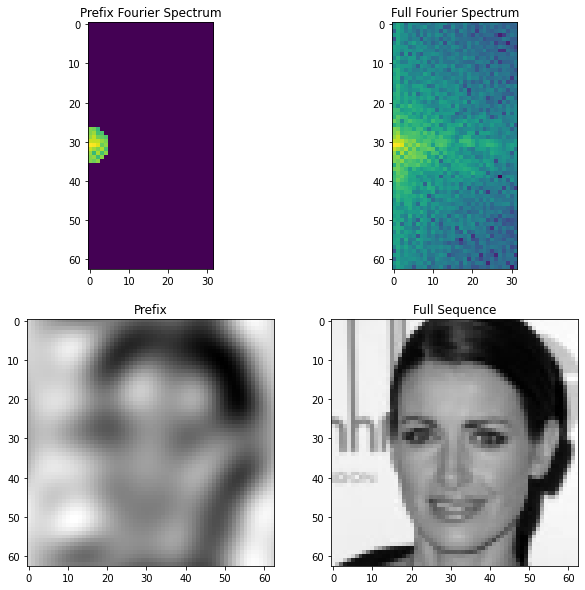

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(torch.roll(torch.log(prefix_dft[0].abs()), dm.gt_shape//2, 0))
plt.title('Prefix Fourier Spectrum')
plt.subplot(2,2,2)
plt.imshow(torch.roll(torch.log(x_dft[0].abs()), dm.gt_shape//2, 0))
plt.title('Full Fourier Spectrum')
plt.subplot(2,2,3)
plt.imshow(torch.fft.irfftn(prefix_dft[0], s=(dm.gt_shape,dm.gt_shape)), cmap='gray')
plt.title('Prefix');
plt.subplot(2,2,4)
plt.imshow(torch.fft.irfftn(x_dft[0], s=(dm.gt_shape,dm.gt_shape)), cmap='gray')
plt.title('Full Sequence');

# Positional Encoding

Since we work with transformers and want to utilize the location information of our data we have to provide it via positional encoding. Fourier spectra are best described by polar-coordinates, hence we use a polar-coordinate based positional encoding.

In [10]:
pos_enc = PositionalEncoding2D(8, (r, phi), flatten_order)

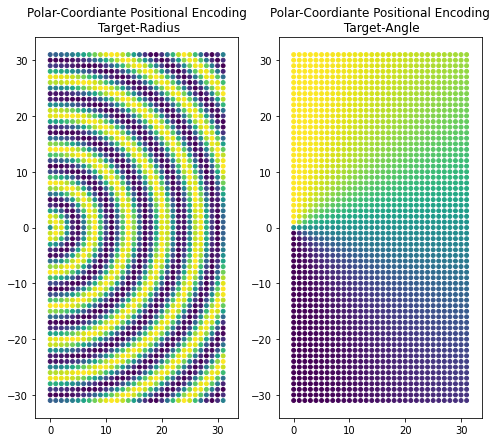

In [11]:
plt.figure(figsize=(8,7))
plt.subplot(1,2,1)
plt.scatter(*pol2cart(r[flatten_order], phi[flatten_order]), c=pos_enc.pe[0,:,0], s=15)
plt.axis('equal');
plt.title('Polar-Coordiante Positional Encoding\n Target-Radius');

plt.subplot(1,2,2)
plt.scatter(*pol2cart(r[flatten_order], phi[flatten_order]), c=pos_enc.pe[0,:,4], s=15)
plt.axis('equal');
plt.title('Polar-Coordiante Positional Encoding\n Target-Angle');